# Projet 10 : Détection de faux billets de banque avec un algorithme

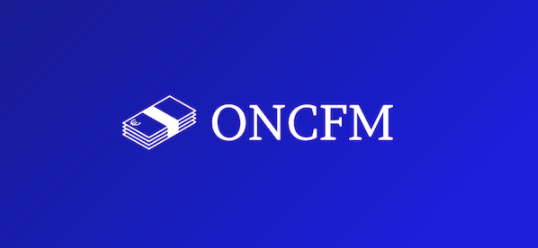

## Sommaire : 

**I) Préparation des données**

**II) Statistiques descriptives**
* **A) Analyses univariées et bivariées**
* **B) Analyse en composantes principales**

**III) Modélisation**
* **A) Clustering**
* **B) Classification**
* **C) Régression**

**III) Choix de l'algorithme final et test**

# I) Préparation des données

Import des librairies et lecture du fichier CSV :

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn import decomposition, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import balanced_accuracy_score

In [2]:
data = pd.read_csv('billets.csv',sep=';')

### Description du DataFrame :

In [3]:
data.head(2)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


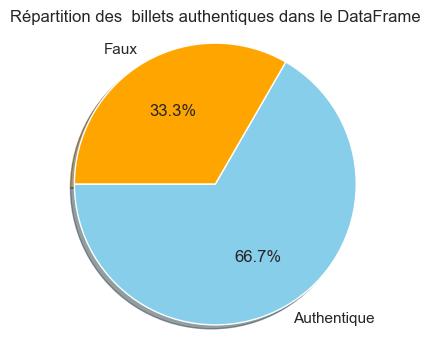

In [5]:
plt.figure(figsize=(4,4))

sns.set_theme(style = "white")

plt.title("Répartition des  billets authentiques dans le DataFrame",size =12)

labels = 'Authentique', 'Faux',
sizes = [data['is_genuine'].sum(),len(data)-data['is_genuine'].sum()]
colors = ['skyblue','orange']

plt.pie(sizes, labels=labels, colors=colors, 
        autopct='%1.1f%%', shadow=True, startangle=180)

plt.axis('equal')


plt.show()

* Le DataSet contient **1500 lignes** et **7 colonnes**
* Il y a **1000 vrais billets** et **500 faux billets**

# II) Statistiques descriptives : 

### Analyses univariées : 

In [6]:
data.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


**Remarques:**

* Les données sont très précises(au centième de mm près)
* Les écart-types sont faibles (<0.9)

Recherche de doublons et valeurs nulles :

In [7]:
def count_doublon(df):
    print('Taille du DataFrame =',len(df))
    count_doublon = len(df)-len(df.drop_duplicates())
    if count_doublon>0:
        percent_doublon = (count_doublon*100)/len(df)
        df_doublon = df[df.duplicated(keep="first")]
        print('Nombre de doublons dans le DataFrame =',count_doublon)
        print('Pourcentage de doublons dans le DataFrame =',percent_doublon,'%')
        print('Liste des doublons :')
        return df_doublon
    else :
        print('Pas de doublons.')

In [8]:
count_doublon(data)

Taille du DataFrame = 1500
Pas de doublons.


In [9]:
def count_null(df):
    columns = df.columns
    list_null = df.isnull().sum().values
    df_null = pd.DataFrame()
    df_null['columns']=columns
    df_null['nb_null']=list_null
    df_null['%_null']=(df_null['nb_null']*100)/len(df)
    return df_null 

In [10]:
count_null(data)

,columns,nb_null,%_null
0,is_genuine,0,0.000000
1,diagonal,0,0.000000
2,height_left,0,0.000000
3,height_right,0,0.000000
4,margin_low,37,2.466667
5,margin_up,0,0.000000
6,length,0,0.000000


**Remarque :** Il y a **37 valeurs nulles** dans la colonne 'margin_low'

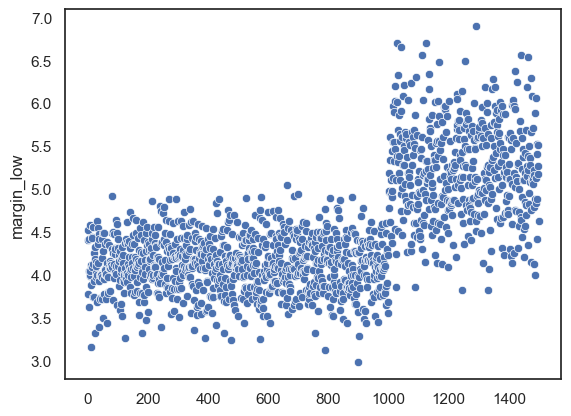

In [11]:
sns.scatterplot(data=data['margin_low'])
plt.show()

**Remarque :** On distingue facilement la différence de distribution entre les vrais et faux billets. 

### Analyses bivariées :

In [12]:
data_heat = data[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up','length']]

In [13]:
data.columns

Index(['is_genuine', 'diagonal', 'height_left', 'height_right', 'margin_low',
       'margin_up', 'length'],
      dtype='object')

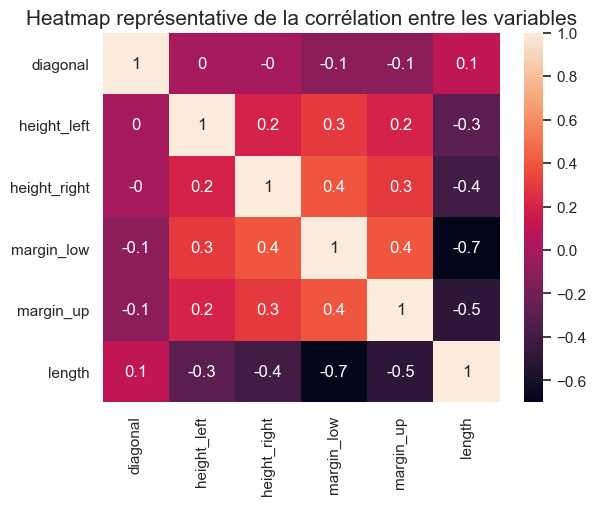

In [14]:
sns.heatmap((data_heat.corr(method='pearson')).round(1), cbar=True, annot=True);
plt.title('Heatmap représentative de la corrélation entre les variables',size=15)
plt.show()

Les 3 variables les plus corrélées au **'margin_low'** sont :

* **length : corrélation négative**
* **margin_up : corrélation positive**
* **height_right : corrélation positive**

C'est donc avec ces 3 variables que nous effectuerons la prédiction (régression linéaire) pour combler les valeurs manquantes de 'margin_low' 

### Test d'homoscédasticité des variables(test de Levene) et normalité des résidus (test de Shapiro) avant régression linéaire:

Les variables testées sont les 3 variables qui semblent être corrélées à 'margin_low'

In [15]:
from scipy.stats import levene
from scipy import stats
import random

In [16]:
def test_levene_shapiro(data) :
    liste = data.values
    # découpage de la variable en 3 listes aléatoires
    a = []
    b = []
    c = []
    for i in range(0,500):
        a.append(random.choice(liste))
        b.append(random.choice(liste))
        c.append(random.choice(liste))
    stat, p = levene(a,b,c)
    print('Test de Levene :')
    print('----------------------------------')
    print('p = ',p)
    if (p<0.05) :
        print('p<0.05 : La variance de la population de la variable est hétérogène')
    else : 
        print('p>0.05 : La variance de la population de la variable est homogène')

    print('Variance des 3 listes :',[np.var(x, ddof=1) for x in [a, b, c]])
    print('')
    print('Test de Shapiro :')
    print('----------------------------------')
    shapiro_test = stats.shapiro(liste)
    shapiro_test

    if(shapiro_test.pvalue<0.05):
        print("p<0.05 : Il est improbable d'obtenir de telles données en supposant qu'elles soient normalement distribuées")
    else :
        print("p>0.05 : La valeur de la p-value alors obtenue ne présuppose en rien de la nature de la distribution des données")

In [17]:
test_levene_shapiro(data['margin_up'])

Test de Levene :
----------------------------------
p =  0.7661480702334225
p>0.05 : La variance de la population de la variable est homogène
Variance des 3 listes : [0.055626767134268534, 0.05007188617234469, 0.056180512625250506]

Test de Shapiro :
----------------------------------
p<0.05 : Il est improbable d'obtenir de telles données en supposant qu'elles soient normalement distribuées


In [18]:
test_levene_shapiro(data['height_right'])

Test de Levene :
----------------------------------
p =  0.4843653689324231
p>0.05 : La variance de la population de la variable est homogène
Variance des 3 listes : [0.10998929218436884, 0.10442069098196384, 0.11210044529058111]

Test de Shapiro :
----------------------------------
p>0.05 : La valeur de la p-value alors obtenue ne présuppose en rien de la nature de la distribution des données


In [19]:
test_levene_shapiro(data['length'])

Test de Levene :
----------------------------------
p =  0.8984195144587249
p>0.05 : La variance de la population de la variable est homogène
Variance des 3 listes : [0.7668873923847693, 0.7291816797595188, 0.7593274933867733]

Test de Shapiro :
----------------------------------
p<0.05 : Il est improbable d'obtenir de telles données en supposant qu'elles soient normalement distribuées


**Les variables retenues pour prédire les valeurs manquantes de 'margin_low' sont donc : 'margin_up' , 'length'**

**Ces variables sont également colinéaire à 'margin_low' (voir ACP)**

### Régression linéaire : Prédiction pour combler les valeurs manquantes de 'margin_low'

Préparation des données avant la régression linéaire :

In [20]:
from sklearn.linear_model import LinearRegression

On se sépare des valeurs nulles :

In [21]:
data_null = data[data['margin_low'].isnull()]
data_no_null = data.dropna()

In [22]:
# Variables explicatives
X = data_no_null[['length','margin_up']]

# Variable à expliquer
y = data_no_null[['margin_low']]

# Variable pour la prédiction des 37 valeurs nulles
Z = data_null[['length','margin_up']]

Création des partitions des données d'entrainement :

In [23]:
# Partition aléatoire du jeu de données en 80% pour créer le modèle, 20% pour tester le modèle
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

print('Train Set :',X_train.shape)
print('Train Test :',X_test.shape)

Train Set : (1170, 2)
Train Test : (293, 2)


Entrainement du modèle :

In [24]:
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

**Evalutation du modèle de régression linéaire :**

On utilise deux métriques pour l’évaluation L’erreur quadratique moyenne (l’erreur d’estimation) et le R-square (la qualité du modèle de régression)

In [25]:
# Evaluation du training set
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
y_train_predict = model.predict(X_train)
rmse = (np.sqrt(mean_squared_error(y_train, y_train_predict)))
r2 = r2_score(y_train, y_train_predict)
 
print('La performance du modèle sur la base dapprentissage')
print('--------------------------------------')
print("L'erreur quadratique moyenne est {}".format(rmse))
print('le score R2 est {}'.format(r2))
print('\n')
 
# evalutation du  testing set
y_test_predict = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, y_test_predict)))
r2 = r2_score(y_test, y_test_predict)
 
print('La performance du modèle sur la base de test')
print('--------------------------------------')
print("L'erreur quadratique moyenne est {}".format(rmse))
print('le score R2 est {}'.format(r2))

La performance du modèle sur la base dapprentissage
--------------------------------------
L'erreur quadratique moyenne est 0.49152318343013973
le score R2 est 0.45355759760662573


La performance du modèle sur la base de test
--------------------------------------
L'erreur quadratique moyenne est 0.4850710768524728
le score R2 est 0.4554738163367009


Remarque : Le R²(carré du coefficient de corrélation linéaire) correspond au pourcentage de détermination de la distribution des points par l'equtation de la droite

**Coefficients de régression linéaire :**

In [26]:
model.coef_

array([[-0.45576413,  0.35463497]])

Pour chaque augmentation d'une unité de [variable X], la [variable y] augmente de [coefficient] lorsque toutes les autres variables sont maintenues constantes.

**Prédiction des valeurs nulles :**

In [27]:
prediction = model.predict(Z)
prediction.shape

(37, 1)

In [28]:
data_null['margin_low'] = prediction
add_values = data_null

<ipython-input-28-11348e6afa17>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_null['margin_low'] = prediction


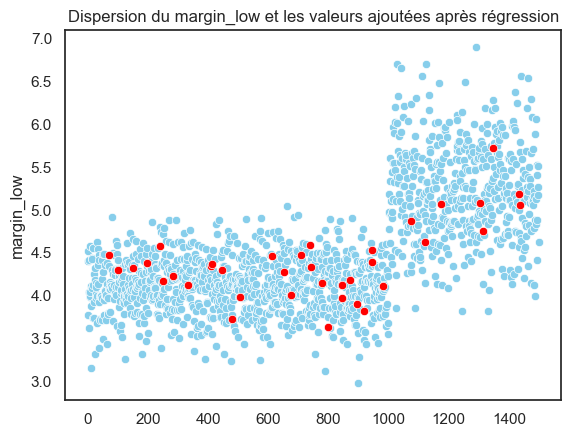

In [29]:
sns.scatterplot(data=data['margin_low'],color='skyblue')
sns.scatterplot(data=add_values['margin_low'],color='red')
plt.title('Dispersion du margin_low et les valeurs ajoutées après régression')
plt.show()

In [30]:
# réintégration des valeurs
j=0
for i in (data_null.index):
    data.iloc[i,4]=prediction[j]
    j +=1

### Détection d'outliers : Méthode des interquartiles

In [31]:
def outliers_quart(data,column,seuil) :
    Q1 = np.percentile(data[column], 25)
    print("Quartile Q1 vaut : ", Q1)
    Q3 = np.percentile(data[column],75)
    print("Quartile Q3 vaut : ", Q3)
    print("L ecart interquartile vaut Q3 - Q1 = ", Q3 - Q1)
    borne_sup = Q3 + 2* (Q3-Q1)
    print('Borne supérieure =',borne_sup)
    outliers_interquartile = data[data[column]>=borne_sup]
    print('Il y a ',len(outliers_interquartile),' outliers')
    return outliers_interquartile

In [32]:
outliers_quart(data,'diagonal',2)

Quartile Q1 vaut :  171.75
Quartile Q3 vaut :  172.17
L ecart interquartile vaut Q3 - Q1 =  0.4199999999999875
Borne supérieure = 173.00999999999996
Il y a  1  outliers


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
1277,False,173.01,104.59,104.31,5.04,3.05,110.91


In [33]:
outliers_quart(data,'height_left',2)

Quartile Q1 vaut :  103.82
Quartile Q3 vaut :  104.23
L ecart interquartile vaut Q3 - Q1 =  0.4100000000000108
Borne supérieure = 105.05000000000003
Il y a  0  outliers


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length


In [34]:
outliers_quart(data,'height_right',2)

Quartile Q1 vaut :  103.71
Quartile Q3 vaut :  104.15
L ecart interquartile vaut Q3 - Q1 =  0.44000000000001194
Borne supérieure = 105.03000000000003
Il y a  0  outliers


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length


In [35]:
outliers_quart(data,'margin_up',2)

Quartile Q1 vaut :  2.99
Quartile Q3 vaut :  3.31
L ecart interquartile vaut Q3 - Q1 =  0.31999999999999984
Borne supérieure = 3.9499999999999997
Il y a  0  outliers


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length


In [36]:
outliers_quart(data,'margin_low',2)

Quartile Q1 vaut :  4.02
Quartile Q3 vaut :  4.87
L ecart interquartile vaut Q3 - Q1 =  0.8500000000000005
Borne supérieure = 6.570000000000001
Il y a  4  outliers


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
1027,False,171.63,104.02,104.66,6.70,3.28,111.28
1041,False,171.77,104.12,104.42,6.65,3.63,111.53
1124,False,171.88,103.92,104.27,6.70,3.11,110.93
1290,False,171.94,104.06,104.22,6.90,3.36,111.70


In [37]:
outliers_quart(data,'length',2)

Quartile Q1 vaut :  112.03
Quartile Q3 vaut :  113.34
L ecart interquartile vaut Q3 - Q1 =  1.3100000000000023
Borne supérieure = 115.96000000000001
Il y a  0  outliers


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length


### Comparaison de la distribution entre les vrais et faux billets:

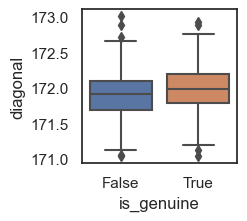

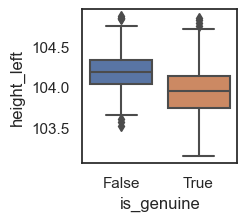

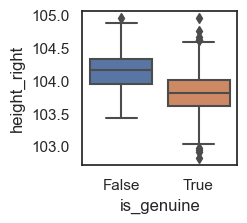

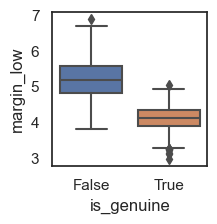

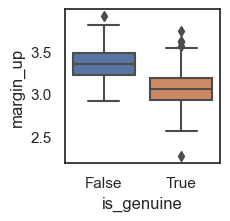

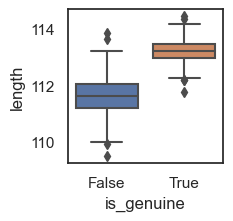

In [38]:
for i in range (1,len(data.columns)):
    plt.figure(figsize=(2,2))
    ax = sns.boxplot(y=data.columns[i],x='is_genuine',data=data)
    plt.show()

Les variables qui semblent les plus discriminantes sont :
* Margin_low
* length

### Standardisation des données : RobustScaler()

In [39]:
from sklearn.preprocessing import RobustScaler

**Remarque :**
Le RobustScaler permet une standardisation plus robuste que le standardScaler car le calcul se base la médiane et l'interquartile qui sont beaucoup moins sensible aux outliers que la moyenne

In [40]:
df=data
#df.index=df['is_genuine']
df = df[['diagonal','height_left', 'height_right', 'margin_low', 'margin_up','length']]
features = df.columns
X = df.values
X

array([[171.81, 104.86, 104.95,   4.52,   2.89, 112.83],
       [171.46, 103.36, 103.66,   3.77,   2.99, 113.09],
       [172.69, 104.48, 103.5 ,   4.4 ,   2.94, 113.16],
       ...,
       [171.8 , 104.01, 104.12,   5.51,   3.36, 111.95],
       [172.06, 104.28, 104.06,   5.17,   3.46, 112.25],
       [171.47, 104.15, 103.82,   4.63,   3.37, 112.07]])

In [41]:
scaler = RobustScaler()
X_norm = scaler.fit_transform(X)
X_norm

array([[-0.35714286,  2.        ,  2.34090909,  0.24117647, -0.78125   ,
        -0.09923664],
       [-1.19047619, -1.65853659, -0.59090909, -0.64117647, -0.46875   ,
         0.09923664],
       [ 1.73809524,  1.07317073, -0.95454545,  0.1       , -0.625     ,
         0.15267176],
       ...,
       [-0.38095238, -0.07317073,  0.45454545,  1.40588235,  0.6875    ,
        -0.77099237],
       [ 0.23809524,  0.58536585,  0.31818182,  1.00588235,  1.        ,
        -0.54198473],
       [-1.16666667,  0.26829268, -0.22727273,  0.37058824,  0.71875   ,
        -0.67938931]])

### Détection d'outliers : IsolationForest

In [42]:
from sklearn.ensemble import IsolationForest
model = IsolationForest(contamination=0.02) #une contamination à 0.01 signifie que l'ont considère qu'il y a 1% d'outliers 
model.fit(X)

IsolationForest(contamination=0.02)

In [43]:
prediction = model.predict(X)

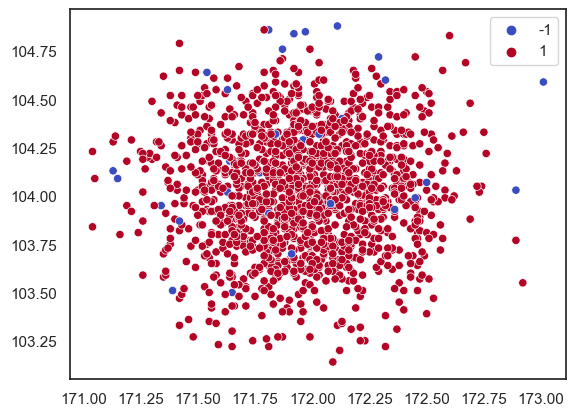

In [44]:
sns.scatterplot(x = X[:,0], y = X[:,1], data = X,hue=prediction, palette = "coolwarm")
plt.show()

**Remarque :** 
Les outliers ne semble pas être des valeurs aberrantes. Le RobustScaler compensera les effets des éventuels outliers. Je conserve donc l'intégralité du DataSet

### Analyse des composantes principales (ACP) : 

In [45]:
from sklearn import decomposition
from sklearn import preprocessing
from functions import *

In [46]:
# choix du nombre de composantes à calculer
n_comp = 6

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)#ici

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

PCA(n_components=6)

**Variance expliquée :**

In [47]:
tab_var = pd.DataFrame(
    {
        "Dimension" : ["F" + str(x + 1) for x in range(n_comp)], 
        "Variance expliquée" : pca.explained_variance_,
        "% variance expliquée" : np.round(pca.explained_variance_ratio_ * 100),
        "% cum. var. expliquée" : np.round(np.cumsum(pca.explained_variance_ratio_) * 100)
    }
)
tab_var

,Dimension,Variance expliquée,% variance expliquée,% cum. var. expliquée
0,F1,2.596419,43.0,43.0
1,F2,1.018005,17.0,60.0
2,F3,0.782447,13.0,73.0
3,F4,0.710751,12.0,85.0
4,F5,0.578090,10.0,95.0
5,F6,0.318291,5.0,100.0


**On arrive à environ 95% de variance expliquée pour 5 dimensions**

**Conclusion :** Pas de réduction des dimensions. La réduction de dimensions aurait été envisagée s'il y avait un grand nombre de variables

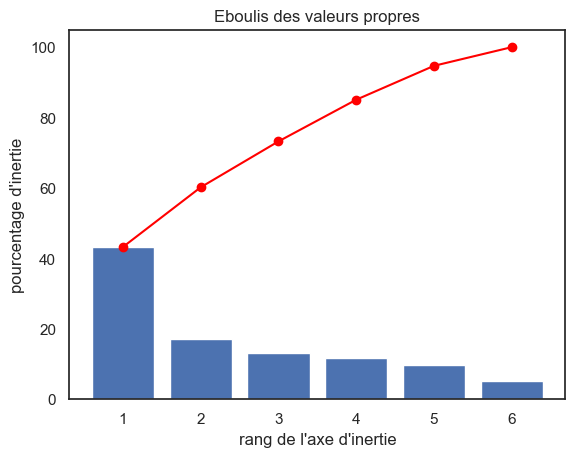

In [48]:
# Eboulis des valeurs propres
display_scree_plot(pca)
plt.show()

In [49]:
features

Index(['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up',
       'length'],
      dtype='object')

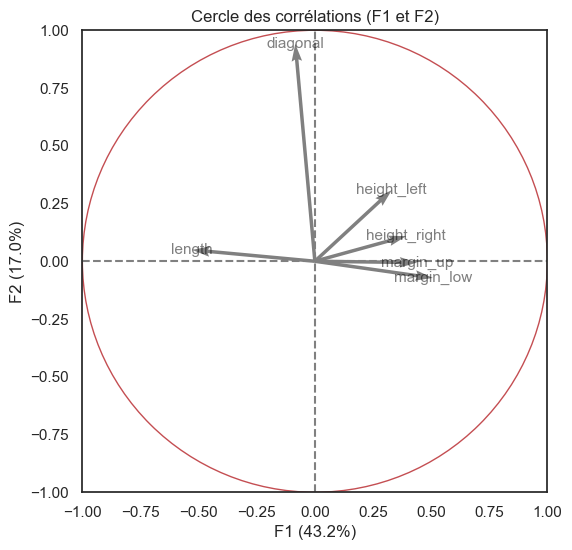

In [50]:
# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))
plt.show()

Il semble y avoir une corrélation entre les marges

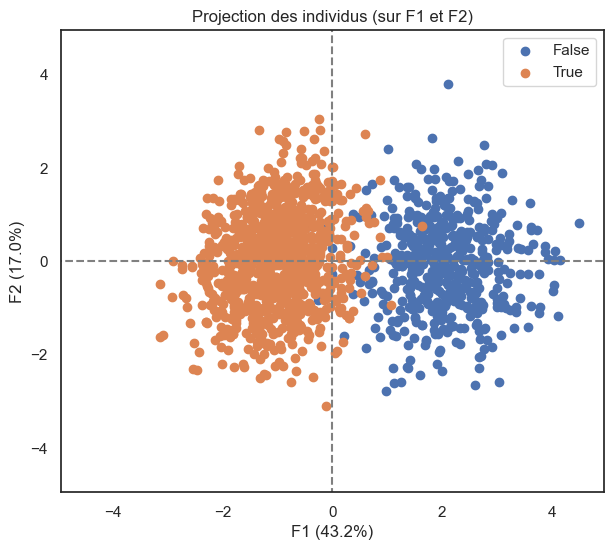

In [51]:
# Projection des individus
X_projected = pca.transform(X_scaled)#ici
display_factorial_planes(X_projected, n_comp, pca, [(0,1)],illustrative_var=data['is_genuine'])

### Train-test split :

In [52]:
# X : Data
# X_norm : Data standardisé

# Variable à expliquer
y = data.is_genuine

# Partition aléatoire du jeu de données en 80% pour créer le modèle, 20% pour tester le modèle
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.20)

print('Train Set :',X_train.shape)
print('Train Test :',X_test.shape)

Train Set : (1200, 6)
Train Test : (300, 6)


#  III) Modélisation :

In [53]:
data.index = data['is_genuine']
del data['is_genuine']

### A) Clustering :  k-means

In [54]:
from sklearn.model_selection import GridSearchCV

In [55]:
km = KMeans(n_clusters=2)
km.fit(X_projected)

KMeans(n_clusters=2)

In [56]:
print('Test score:',km.score(X_projected))

Test score: -5807.4148289319555


In [57]:
# Récupération des clusters attribués à chaque individu
clusters = km.labels_

In [58]:
confusion_matrix = pd.crosstab(clusters,data.index)
confusion_matrix

col_0,False,True
row_0,,
0,13,990
1,487,10


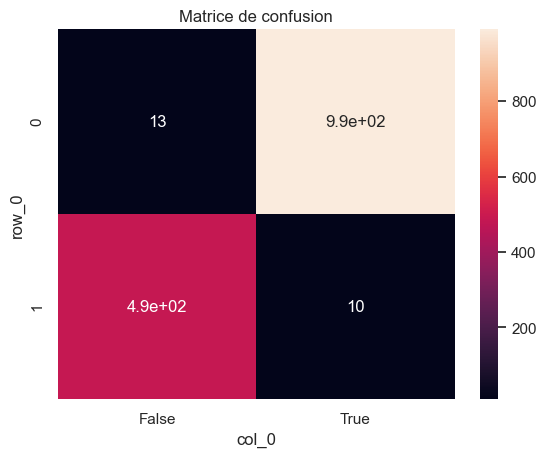

In [59]:
sns.heatmap(confusion_matrix, annot=True)
plt.title('Matrice de confusion')
plt.show()

**Calcul de l'efficacité du model :**

In [60]:
score_kmeans = 1-((confusion_matrix.iloc[0,0] + confusion_matrix.iloc[1,1])/len(data))
score_kmeans

0.9846666666666667

**Efficacité proche de 100%**

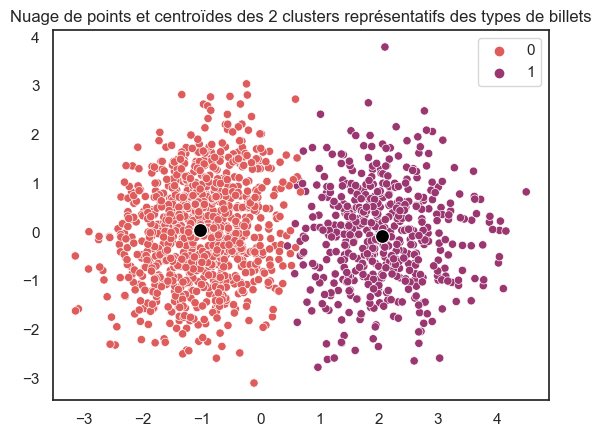

In [61]:
from sklearn.exceptions import NotFittedError

sns.scatterplot(x = X_projected[:,0], y = X_projected[:,1], data = X_projected,hue=clusters, palette = "flare")
sns.scatterplot(x=km.cluster_centers_[:,0],y=km.cluster_centers_[:,1],color='black',s=100)
plt.title('Nuage de points et centroïdes des 2 clusters représentatifs des types de billets')
plt.show()

**Test de l'algorithme :**

In [62]:
def test_kmeans(fichier_test) :
    df_test=pd.read_csv(fichier_test,sep=',')
    test = df_test.drop(['id'], axis=1).values
    test_scaler = scaler.transform(test)
    test_projected = pca.transform(test_scaler)
    probabilities = km.predict(test_projected)
    df_resultat = pd.DataFrame({'ID':df_test['id'],
                                'Nature':probabilities})
    print(df_resultat)
    print('Nombre de faux billets :',sum(df_resultat['Nature']))
    print('Nombre de vrais billets :',len(df_resultat) - sum(df_resultat['Nature']))
    print('% de vrais billets :',round(((len(df_resultat) - sum(df_resultat['Nature']))*100)/len(df_resultat)),'%')
    
    df_resultat.to_csv('resultat_test_kmeans.csv')
    
    plt.figure(figsize=(4,4))
    plt.title("Répartition des  billets authentiques dans le DataFrame",size =12)

    labels = 'Authentique', 'Faux',
    sizes = [len(df_resultat) - sum(df_resultat['Nature']),sum(df_resultat['Nature'])]
    colors = ['skyblue','orange']

    plt.pie(sizes, labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=180)
    plt.axis('equal')
    plt.show()

    ID  Nature
0  A_1       1
1  A_2       1
2  A_3       1
3  A_4       0
4  A_5       0
Nombre de faux billets : 3
Nombre de vrais billets : 2
% de vrais billets : 40 %


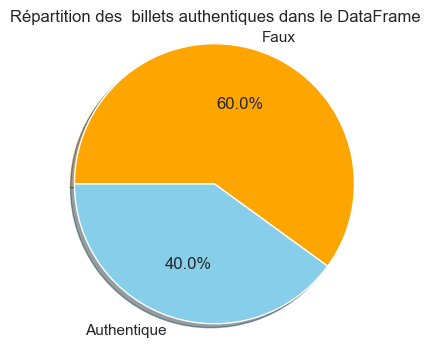

In [63]:
test_kmeans('billets_production.csv')

**Calcul de l'inertie en fonction du nombre de clusters**

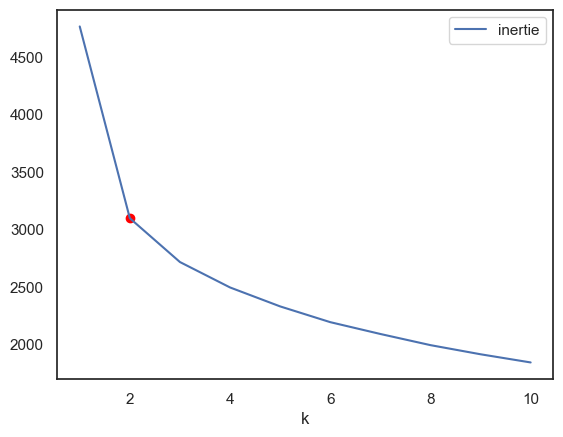

In [64]:
inertie = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters = k, init = "random", n_init = 20).fit(X_norm)
    inertie = inertie + [kmeans.inertia_]
inertie = pd.DataFrame({"k": range(1, 11), "inertie": inertie})
inertie.plot.line(x = "k", y = "inertie")
plt.scatter(2, inertie.query('k == 2')["inertie"], c = "red")

plt.show()

### B) Classification :  KNN

In [65]:
from sklearn.neighbors import KNeighborsClassifier

In [66]:
model = KNeighborsClassifier() #n_neighbors = ? ,quel nombre de voisins donnent le meilleur résultats ?
model.fit(X_train,y_train)
print('Train score :',model.score(X_train,y_train))
print('Test score:',model.score(X_test,y_test))

Train score : 0.9916666666666667
Test score: 0.9966666666666667


**Cross-validation :**

In [67]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, LeaveOneOut # decoupe autant de ffois qu'il y a d'individu , à éviter avec les gros DataSet

In [68]:
cv = LeaveOneOut()
cross_val_score(KNeighborsClassifier(),X_train,y_train, cv=cv).mean() # cv = nombre de split

0.9908333333333333

**Validation curve :**

In [69]:
from sklearn.model_selection import validation_curve

In [70]:
k = np.arange(1,50)

In [71]:
train_score, val_score = validation_curve(model, X_train, y_train,'n_neighbors', k,cv=5)

C:\Users\NK\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass param_name=n_neighbors, param_range=[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


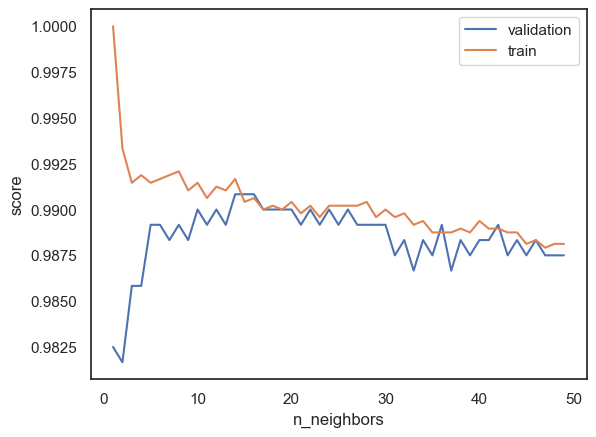

In [72]:
plt.plot(k, val_score.mean(axis=1), label='validation')
plt.plot(k, train_score.mean(axis=1), label='train')
plt.xlabel('n_neighbors')
plt.ylabel('score')
plt.legend()
plt.show()

In [73]:
val_score.mean(axis=1)

array([0.9825    , 0.98166667, 0.98583333, 0.98583333, 0.98916667,
       0.98916667, 0.98833333, 0.98916667, 0.98833333, 0.99      ,
       0.98916667, 0.99      , 0.98916667, 0.99083333, 0.99083333,
       0.99083333, 0.99      , 0.99      , 0.99      , 0.99      ,
       0.98916667, 0.99      , 0.98916667, 0.99      , 0.98916667,
       0.99      , 0.98916667, 0.98916667, 0.98916667, 0.98916667,
       0.9875    , 0.98833333, 0.98666667, 0.98833333, 0.9875    ,
       0.98916667, 0.98666667, 0.98833333, 0.9875    , 0.98833333,
       0.98833333, 0.98916667, 0.9875    , 0.98833333, 0.9875    ,
       0.98833333, 0.9875    , 0.9875    , 0.9875    ])

**GridSearchCV :** 

Permet de trouver le modèle avec les meilleurs hyper paramètres en comparant les différences de chaques combinaisons grâce à la technique de cross-validation

In [74]:
from sklearn.model_selection import GridSearchCV

In [75]:
param_grid = {'n_neighbors' : np.arange(1,20),
             'metric' : ['euclidian','manhattan']}

grid = GridSearchCV(model,param_grid, cv=5)

grid.fit(X_train,y_train)

C:\Users\NK\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\NK\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\NK\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 179, in fit
    return self._fit(X, y)
  File "C:\Users\NK\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 399, in _fit
    self._check_algorithm_metric()
  File "C:\Users\NK\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 342, in _check_algorithm_metric
    raise ValueError("Metric '%s' not valid. Use "
ValueError: Metric 'euclidian' not valid. Use sorted(sklearn.neighbors.VALID_METRICS['brute']) to get valid options. Metric can also be a callable function.



C:\Users\NK\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\NK\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\NK\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 179, in fit
    return self._fit(X, y)
  File "C:\Users\NK\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 399, in _fit
    self._check_algorithm_metric()
  File "C:\Users\NK\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 342, in _check_algorithm_metric
    raise ValueError("Metric '%s' not valid. Use "
ValueError: Metric 'euclidian' not valid. Use sorted(sklearn.neighbors.VALID_METRICS['brute']) to get valid options. Metric can also be a callable function.



C:\Users\NK\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan 0.98083333 0.98       0.98583333 0.98583333 0.98833333
 0.9875     0.98583333 0.98583333 0.985      0.98583333 0.98583333
 0.98916667 0.98833333 0.99       0.98916667 0.98833333 0.98833333
 0.9875     0.98833333]
  warnings.warn(


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidian', 'manhattan'],
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])})

In [76]:
grid.best_score_ #meilleur score attribué

0.99

In [77]:
grid.best_params_ # meilleurs paramètres attribués

{'metric': 'manhattan', 'n_neighbors': 14}

In [78]:
KNN = grid.best_estimator_ # sauvegarde du model avec les meilleurs paramètres

In [79]:
score_KNN = KNN.score(X_test,y_test) # % de réussite du modèle
score_KNN

0.9933333333333333

**Matrice de confusions :**

In [80]:
from sklearn.metrics import confusion_matrix

In [81]:
confusion_matrix = confusion_matrix(y_test,model.predict(X_test))

In [82]:
confusion_matrix

array([[106,   1],
       [  0, 193]], dtype=int64)

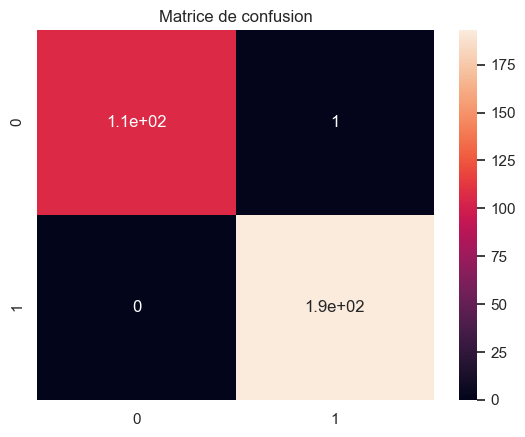

In [83]:
sns.heatmap(confusion_matrix, annot=True)
plt.title('Matrice de confusion')
plt.show()

**Test de l'algorithme :**

In [84]:
def test_KNN(fichier_test) :
    df_test=pd.read_csv(fichier_test,sep=',')
    test = df_test.drop(['id'], axis=1).values
    test_scaler = scaler.transform(test)
    probabilities = KNN.predict(test_scaler)
    df_resultat = pd.DataFrame({'ID':df_test['id'],
                                'Nature':probabilities,
                                'Proba_True':KNN.predict_proba(test_scaler)[:,1],
                                'Proba_False':1-KNN.predict_proba(test_scaler)[:,1]})
    print(df_resultat)
    print('Nombre de vrais billets :',sum(df_resultat['Nature']))
    print('Nombre de faux billets :',len(df_resultat) - sum(df_resultat['Nature']))
    
    df_resultat.to_csv('resultat_test_KNN.csv')
    
    plt.figure(figsize=(4,4))
    plt.title("Répartition des  billets authentiques dans le DataFrame",size =12)

    labels = 'Authentique', 'Faux',
    sizes = [sum(df_resultat['Nature']),len(df_resultat) - sum(df_resultat['Nature'])]
    colors = ['skyblue','orange']

    plt.pie(sizes, labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=180)
    plt.axis('equal')
    plt.show()

    ID  Nature  Proba_True  Proba_False
0  A_1   False         0.0          1.0
1  A_2   False         0.0          1.0
2  A_3   False         0.0          1.0
3  A_4    True         1.0          0.0
4  A_5    True         1.0          0.0
Nombre de vrais billets : 2
Nombre de faux billets : 3


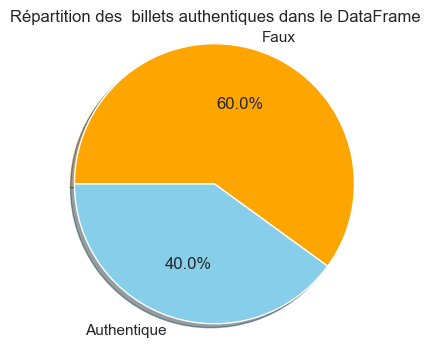

In [85]:
test_KNN('billets_production.csv')

### C) Regression logistique

In [86]:
from sklearn.linear_model import LogisticRegression
from scrapy.selector import Selector

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.api import Logit

In [87]:
model = LogisticRegression()
model.fit(X_train,y_train)
print('Train score :',model.score(X_train,y_train))
print('Test score:',model.score(X_test,y_test))

Train score : 0.9916666666666667
Test score: 0.99


**Nous avons des performances proches de 100% , c'est encore un très bon résultat mais légèrement inférieur au KNN**

In [88]:
param_grid = {'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

grid = GridSearchCV(model,param_grid, cv=5)

grid.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']})

In [89]:
grid.best_params_ # meilleurs paramètres attribués

{'solver': 'newton-cg'}

In [90]:
model_reg = grid.best_estimator_ # sauvegarde du model avec les meilleurs paramètres

**Coefficients de régression logistique:**

In [91]:
import statsmodels.api as sm

In [92]:
# on ajoute une colonne pour la constante
x_stat = sm.add_constant(X_norm)
# on ajuste le modèle
model = sm.Logit(y,X_norm)
result = model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.193688
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             is_genuine   No. Observations:                 1500
Model:                          Logit   Df Residuals:                     1494
Method:                           MLE   Df Model:                            5
Date:                Wed, 22 Dec 2021   Pseudo R-squ.:                  0.6957
Time:                        13:17:09   Log-Likelihood:                -290.53
converged:                       True   LL-Null:                       -954.77
Covariance Type:            nonrobust   LLR p-value:                4.319e-285
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4180      0.144      2.894      0.004       0.135       0.701
x2            -0.7560      0.148     -5.118      0.000      -1.045      -0.466
x3            -1.1284      0.171     -6.595      0.000      -1.464      -0.793
x4            -3.4943      0.325    -10.758      0.000      -4.131      -2.858
x5            -1.8066      0.198     -9.116      0.000      -2.195      -1.418
x6             5.1831      0.449     11.534      0.000       4.302       6.064
==============================================================================

Possibly complete quasi-separation: A fraction 0.23 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

**Score du modèle :**

In [93]:
score_reg_log = model_reg.score(X_test,y_test) # % de réussite du modèle
score_reg_log

0.99

**Test de l'algorithme de test du modèle :**

In [94]:
def test_regression_logistique(fichier_test) :
    df_test=pd.read_csv(fichier_test,sep=',')
    test = df_test.drop(['id'], axis=1).values
    test_scaler = scaler.transform(test)
    probabilities = model_reg.predict(test_scaler)
    df_resultat = pd.DataFrame({'ID':df_test['id'],
                                'Nature':probabilities,
                                'Proba_True':model_reg.predict_proba(test_scaler)[:,1],
                                'Proba_False':1-model_reg.predict_proba(test_scaler)[:,1]})
    print(df_resultat)
    print('Nombre de vrais billets :',sum(df_resultat['Nature']))
    print('Nombre de faux billets :',len(df_resultat) - sum(df_resultat['Nature']))
    
    df_resultat.to_csv('resultat_test_reg_log.csv')
    
    plt.figure(figsize=(4,4))
    plt.title("Répartition des  billets authentiques dans le DataFrame",size =12)

    labels = 'Authentique', 'Faux',
    sizes = [sum(df_resultat['Nature']),len(df_resultat) - sum(df_resultat['Nature'])]
    colors = ['skyblue','orange']

    plt.pie(sizes, labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=180)
    plt.axis('equal')
    plt.show()

    ID  Nature  Proba_True  Proba_False
0  A_1   False    0.004989     0.995011
1  A_2   False    0.000584     0.999416
2  A_3   False    0.000979     0.999021
3  A_4    True    0.957483     0.042517
4  A_5    True    0.999539     0.000461
Nombre de vrais billets : 2
Nombre de faux billets : 3


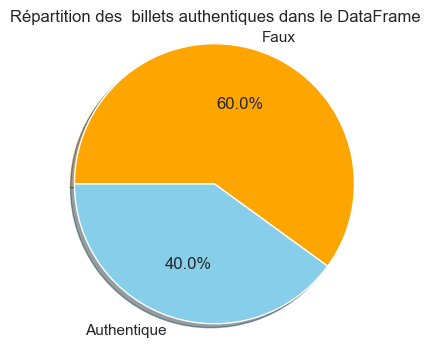

In [95]:
test_regression_logistique('billets_production.csv')

# Bilan :

**Comparaison de l'efficacité des modèles k-means et régression logistique**

In [96]:
score_kmeans

0.9846666666666667

In [97]:
score_reg_log

0.99

In [98]:
score_KNN

0.9933333333333333

In [99]:
score_kmeans<score_reg_log

True

**L'objectif initial était de confronté le k-means et la régression logistique et la régression logistique affiche un meilleur score que celle de la méthode non-supervisée des k-means: J'opte donc pour la méthode des k-means pour l'algorithme final**

# IV) Phase de test :

    ID  Nature  Proba_True  Proba_False
0  B_1    True    0.992209     0.007791
1  B_2   False    0.008986     0.991014
2  B_3    True    0.998669     0.001331
3  B_4   False    0.000187     0.999813
4  B_5   False    0.022131     0.977869
Nombre de vrais billets : 2
Nombre de faux billets : 3


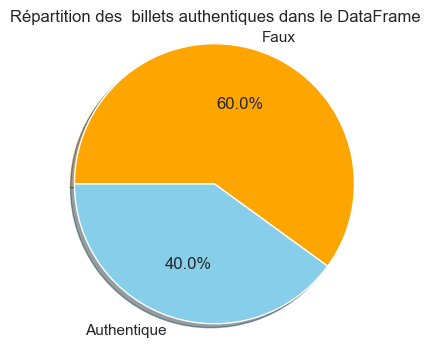

In [100]:
test_regression_logistique('billets_test.csv')
#test_kmeans('billets_production.csv')
#test_KNN('billets_production.csv')